In [1]:
import numpy as np
import pandas as pd
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
import joblib
import anndata

from scipy.stats import pearsonr, ranksums

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
from tqdm import tqdm

def compute_domain_size(i):
    global res, sc_border
    tmp = sc_border.raw.X[i]
    tmp = np.repeat(tmp.indices, tmp.data).reshape((-1, 2))
    return (tmp[:, 1] - tmp[:, 0]).sum() * res

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
from amb import *
age_dict = get_age_palette()
age_dict['8wk'] = age_dict['2mo']

In [3]:
res = 25000

In [4]:
all_cts = [file_path.split('/')[-1] for file_path in glob('CellType.Age.Diff.Domain/*') if file_path.split('/')[-1] != 'notebooks']
len(all_cts)

40

In [5]:
meta_file = '/data/metadata/240104_m3C_META.csv'
metadata = pd.read_csv(meta_file, index_col = 0)
metadata['AgingMajorType'] = metadata['AgingMajorType'].apply(lambda x: x.replace(' ','_').replace('/',''))
metadata = metadata[['AgingMajorType','Age','Replicate']]
metadata['AgingMajorType.Age'] = metadata['AgingMajorType'].astype(str) + '.' + metadata['Age'].astype(str)

In [6]:
ct_pvalue = {}
to_plot_meta = []

for ct in tqdm(all_cts): 
    sc_border = anndata.read_h5ad(f'CellType.Age.Diff.Domain/{ct}/{ct}_cell_boundary.h5ad')
    tmp_metadata= metadata.loc[sc_border.obs_names]

    ncpu = 20
    domain_size, cell_list = [], []
    with ProcessPoolExecutor(ncpu) as exe:
        future_dict = {}
        for i,cell in enumerate(tmp_metadata.index):
            future = exe.submit(compute_domain_size, i=i)
            future_dict[future] = cell
    
        for future in as_completed(future_dict):
            cell = future_dict[future]
            # print(f'{cell} finished.')
            domain_size.append(future.result())
            cell_list.append(cell)
    domain_size = pd.Series(domain_size, index=cell_list)
    tmp_metadata['domain_coverage'] = domain_size.copy()
    tmp_metadata.loc[sc_border.obs.index, 'domain_count'] = sc_border.raw.X.sum(axis=1).A1 / 2
    
    tmp_metadata.loc[sc_border.obs.index, 'boundary_count'] = sc_border.raw.X.getnnz(axis=1)
    
    tmp_metadata['domain_size'] = tmp_metadata['domain_coverage'] / tmp_metadata['domain_count']
    
    stats,p_value = ranksums(tmp_metadata.loc[tmp_metadata['Age'].isin(['8wk']), 'domain_count'], 
         tmp_metadata.loc[tmp_metadata['Age'].isin(['18mo']), 'domain_count'])
    
    if p_value < 1e-10:
        ct_pvalue[ct] = p_value
        to_plot_meta.append(tmp_metadata)

100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


In [7]:
to_plot_meta = pd.concat(to_plot_meta)
to_plot_meta.head()

,AgingMajorType,Age,Replicate,AgingMajorType.Age,domain_coverage,domain_count,boundary_count,domain_size
AMB_220714_18mo_3F_4E_2_P4-4-G10-L8,Vip_Gaba,18mo,rep1,Vip_Gaba.18mo,2396925000,3923.0,4412.0,610992.862605
AMB_220719_18mo_8E_9H_8J_9J_2_P1-6-D6-C23,Vip_Gaba,18mo,rep1,Vip_Gaba.18mo,2419825000,3840.0,4237.0,630162.760417
AMB_220616_18mo_12D_13B_1_P1-5-C23-E9,Vip_Gaba,18mo,rep2,Vip_Gaba.18mo,2415200000,3903.0,4315.0,618806.046631
AMB_220628_18mo_7H_8H_9G_1_P3-2-A11-B3,Vip_Gaba,18mo,rep2,Vip_Gaba.18mo,2430825000,3496.0,3792.0,695316.075515
AMB_220712_18mo_7H_8H_9G_2_P4-6-C7-E12,Vip_Gaba,18mo,rep1,Vip_Gaba.18mo,2414675000,3887.0,4288.0,621218.163108


In [11]:
shared_use_cts = joblib.load('/home/qzeng_salk_edu/project/shared_use_cts')
shared_use_cts = [ct.replace('/','').replace(' ','_') for ct in shared_use_cts]

In [13]:
order = ['Oligo_NN','Microglia_NN', 'OPC_NN', 'Astro-TE_NN', 'VLMC_NN',
         'Vip_Gaba', 'Pvalb_Gaba', 'Lamp5_Gaba','Sst_Gaba',
         'CEA-BST_Gaba','STR-PAL_Chst9_Gaba', 'MEA-BST_Gaba',
        'L23_IT_CTX_Glut', 'L23_IT_PPP_Glut','L23_IT_ENT_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut', 'L6bCT_ENT_Glut',
        'CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut', 
        'LA-BLA-BMA-PA_Glut',  'SUB-ProS_Glut', 'MEA-COA_Glut', ]

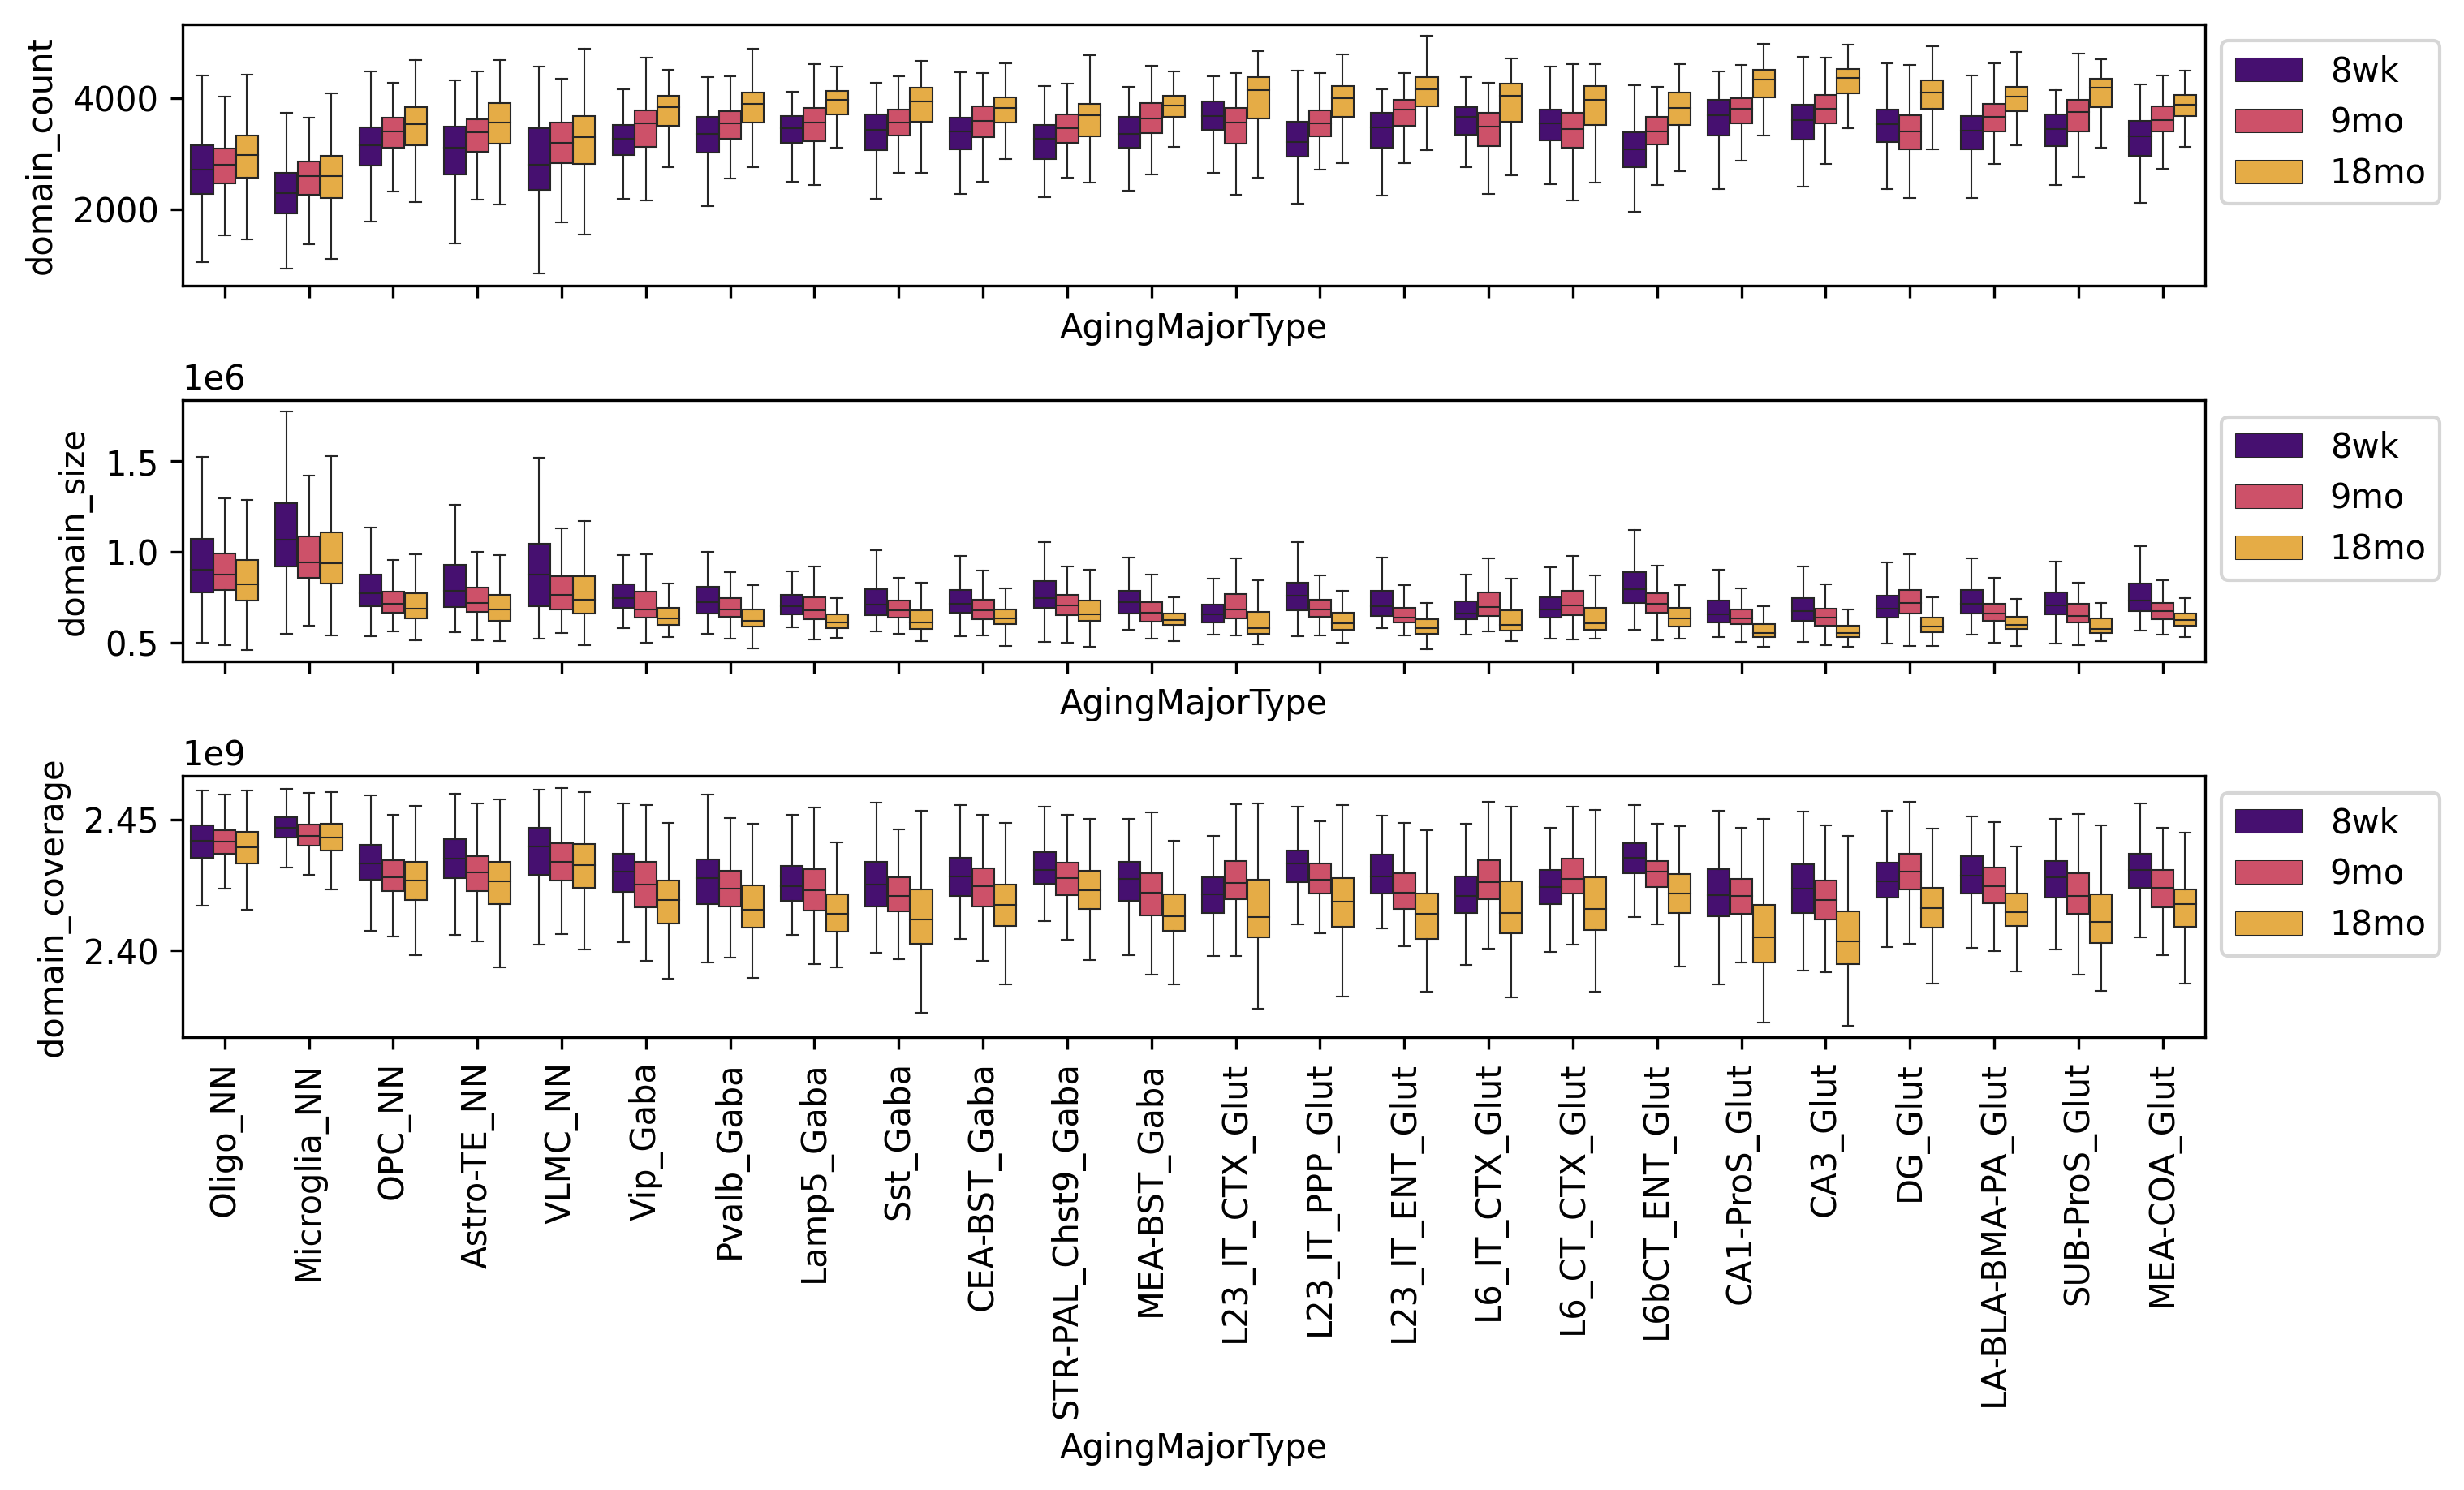

In [11]:
x= 'AgingMajorType'
hue = 'Age'
hue_order = ['8wk','9mo','18mo']
fig, axes = plt.subplots(nrows = 3,ncols = 1, figsize = (10,6), dpi = 300, sharex = True, constrained_layout = True)

ax = axes[0]
y = 'domain_count'
sns.boxplot(data=to_plot_meta, 
            order = order, 
            ax = ax, 
            x=x, y=y, 
            hue=hue,
            linewidth=0.5,
            hue_order = hue_order,
            palette=age_dict,
            showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_ylim(-2,1.5)
ax.set_ylabel(y)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


ax = axes[1]
y = 'domain_size'
sns.boxplot(data=to_plot_meta, 
            order = order, 
            ax = ax, 
            x=x, y=y, 
            hue=hue,
            linewidth=0.5,
            hue_order = hue_order,
            palette=age_dict,
            showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_ylim(-2,1.5)
ax.set_ylabel(y)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


ax = axes[2]
y = 'domain_coverage'
sns.boxplot(data=to_plot_meta, 
            order = order, 
            ax = ax, 
            x=x, y=y, 
            hue=hue,
            linewidth=0.5,
            hue_order = hue_order,
            palette=age_dict,
            showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_ylim(-2,1.5)
ax.set_ylabel(y)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.savefig(f"figure/Domain.Summary.pdf", bbox_inches = 'tight')

In [29]:
# fig, ax = plt.subplots(figsize = (10,5), dpi = 200)
# sns.boxplot(data=to_plot_meta, 
#             ax = ax, 
#             x=x, y=y, 
#             hue=hue,
#             linewidth=0.5,
#             hue_order = hue_order,
#             palette=age_dict,
#             showfliers=False)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# #ax.set_ylim(-2,1.5)
# ax.set_ylabel(y)
# legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.show()

In [1]:
!pwd

/home/qzeng_salk_edu/project/240205-domain
